# ULMFiT on YELP-BI

In [1]:
import pandas as pd
import csv
import json
import sys
sys.path.append('/home/ubuntu/fastai')
from fastai.text import *

In [2]:
path = Config().data_path()/'yelp/'; path

PosixPath('/home/ubuntu/.fastai/data/yelp')

In [3]:
!ls {path}

data_clas.pkl				 yelp_academic_dataset_checkin.json
data_lm.pkl				 yelp_academic_dataset_review.json
Dataset_Challenge_Dataset_Agreement.pdf  yelp_academic_dataset_tip.json
models					 yelp_academic_dataset_user.json
reviews.csv				 yelp-dataset.zip
yelp_academic_dataset_business.json


In [4]:
file_name = "yelp_academic_dataset_review.json"

## Data Preparation

In [5]:
%%time
reviews = pd.read_json(f'{path}/{file_name}', lines=True)

CPU times: user 1min 22s, sys: 17 s, total: 1min 39s
Wall time: 2min 31s


In [6]:
reviews.head()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,ujmEBvifdJM6h6RLv4wQIg,0,2013-05-07 04:34:36,1,Q1sbwvVQXV2734tPgoKj4Q,1,Total bill for this horrible service? Over $8G...,6,hG7b0MtEbXx5QzbzE6C_VA
1,NZnhc2sEQy3RmzKTZnqtwQ,0,2017-01-14 21:30:33,0,GJXCdrto3ASJOqKeVWPi6Q,5,I *adore* Travis at the Hard Rock's new Kelly ...,0,yXQM5uF2jS6es16SJzNHfg
2,WTqjgwHlXbSFevF32_DJVw,0,2016-11-09 20:09:03,0,2TzJjDVDEuAW6MR5Vuc1ug,5,I have to say that this office really has it t...,3,n6-Gk65cPZL6Uz8qRm3NYw
3,ikCg8xy5JIg_NGPx-MSIDA,0,2018-01-09 20:56:38,0,yi0R0Ugj_xUx_Nek0-_Qig,5,Went in for a lunch. Steak sandwich was delici...,0,dacAIZ6fTM6mqwW5uxkskg
4,b1b1eb3uo-w561D0ZfCEiQ,0,2018-01-30 23:07:38,0,11a8sVPMUFtaC7_ABRkmtw,1,Today was my second out of three sessions I ha...,7,ssoyf2_x0EQMed6fgHeMyQ


In [7]:
%%time
reviews = reviews.loc[:,['stars', 'text']]

CPU times: user 156 ms, sys: 20 ms, total: 176 ms
Wall time: 175 ms


In [8]:
%%time
reviews['length'] = reviews['text'].apply(lambda x: len(x))
reviews.sort_values('length', inplace=True, ascending=False)
reviews = reviews[reviews['length']>200]
reviews.drop('length', axis=1, inplace=True)

CPU times: user 7.09 s, sys: 404 ms, total: 7.49 s
Wall time: 6.97 s


In [9]:
reviews = reviews[reviews.stars.isin([1,5])]

In [10]:
reviews['is_valid'] = False 

In [11]:
reviews.columns=['label', 'text', 'is_valid']
reviews.head()

,label,text,is_valid
291007,1,This is a copy of my email to Home Depot Custo...,False
3148987,5,"Items Selected:\nBacon candle\nDutch baby, cas...",False
437977,1,Where to start... the first week they had it t...,False
2037907,1,"Buyer beware of Meritage Homes in the Raleigh,...",False
5626085,1,Nightmare on My Birthday....\n\nI've never had...,False


In [12]:
reviews.label.value_counts()

5    2195765
1     873288
Name: label, dtype: int64

In [13]:
# running our model for smaller subset for faster training
# also making neg, pos reviews baalnced for easier training 
neg = reviews[reviews.label==1][:10000]
pos = reviews[reviews.label==5][:10000]
sample_reviews = pd.concat([neg, pos])

In [14]:
# shuffling sample_reviews
rdm_idx = np.random.RandomState(seed=123).permutation(len(sample_reviews))
sample_reviews = sample_reviews.iloc[rdm_idx]
num_valid = int(0.1 * sample_reviews.shape[0])
sample_reviews.iloc[-num_valid:, 2] = True 
sample_reviews.head()

,label,text,is_valid
2163927,5,Hi all. Wanted to give a 6 month update - pros...,False
2412472,5,In the mood for some Afghani food but don't kn...,False
6631856,5,Pick Thai is absolutely the best!! This chef k...,False
2733135,1,I've been a member at this gym for ~2 years. M...,False
5973262,1,Do not buy from this company and site. I've ha...,False


## DataBunch

In [15]:
bs=64

In [16]:
# data = (TextList.from_df(sample_reviews, path, cols='text')
#                 .split_from_df(col=2)
#                 .label_for_lm()
#                 .databunch(bs=64))
# data.save('data_lm.pkl')

In [17]:
data = load_data(path, 'data_lm.pkl', bs=bs)

In [18]:
data.show_batch()

idx,text
0,"be prepared for a lengthy process of getting plans approved , work scheduled , inspections scheduled and approved etc . xxmaj it took a while for ours to get done , but it was worth the wait . xxmaj our roof has flat cement tiles - easier to walk on and install stuff on , i 'm not aware of any damaged tiles , but if your roof has those"
1,"kind of frequency is absolutely inexcusable . \n \n * xxmaj during the night , the staff member on duty is supposed to check on everyone in ten to fifteen - minute intervals . xxmaj this happened only rarely , sometimes with more than half an hour passing between checks . \n \n * xxmaj here 's the big one ... i was assaulted while staying overnight ."
2,"away with amazement just as you did ... i told you i will email you the video ... xxmaj that takes time to upload to xxmaj dropbox because i have a super slow xxmaj internet connection . xxmaj if you would have read the email . , which obviously you did n't , you would have had a sd card with you , which you did n't . i kindly"
3,"people answering the phone each time i called . xxmaj vanessa , xxmaj mike , xxmaj lance , xxmaj victoria , xxmaj jean , xxmaj xxunk , xxmaj jack , xxmaj chris , xxmaj alex , xxmaj geneva , xxmaj jeremy and the voice mail for xxmaj sarah . xxmaj mike told me that my job was a low priority . xxmaj additionally , i was transferred several times to"
4,"worked with me to get a better furnace than the one the home warranty recommended and told me i could pay with a credit card . xxmaj rocco is awesome : he 'll work with you and will listen to your wants and needs . \n xxmaj so , 5 days later , they have the replacement furnace and parts and were ready to install ( super awesome because"


## Universal Language Model

In [19]:
learn = language_model_learner(data, AWD_LSTM, drop_mult=0.3)

In [20]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


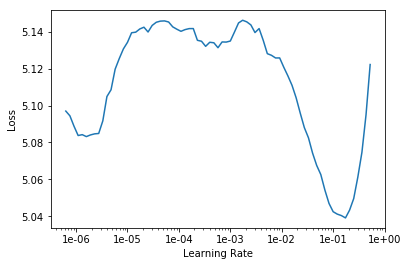

In [21]:
learn.recorder.plot(skip_end=15)

In [22]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

In [23]:
# learn.save('fit_head')

In [24]:
learn.load('fit_head');

In [25]:
learn.unfreeze()

In [26]:
learn.lr_find()

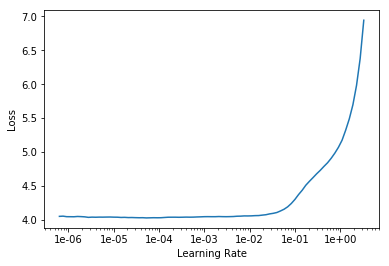

In [27]:
learn.recorder.plot()

In [28]:
learn.fit_one_cycle(5, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.870191,3.831783,0.288089,52:13
1,3.803715,3.734362,0.300142,52:14
2,3.696414,3.669889,0.307982,52:16
3,3.566438,3.635856,0.312447,52:15
4,3.516726,3.629515,0.313139,52:10


In [29]:
# learn.save('finetuned_lm')

In [30]:
learn.load('finetuned_lm')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (18000 items)
x: LMTextList
xxbos xxmaj hi all . xxmaj wanted to give a 6 month update - pros and con 's and some good tips . i apologize to folks that sent me messages directly , i did n't realize how yelp messages worked . 
 
  xxmaj first off , getting electrical construction stuff done to your house is very difficult . xxmaj there are lots of permits and approvals required . xxmaj be prepared for a lengthy process of getting plans approved , work scheduled , inspections scheduled and approved etc . xxmaj it took a while for ours to get done , but it was worth the wait . xxmaj our roof has flat cement tiles - easier to walk on and install stuff on , i 'm not aware of any damaged tiles , but if your roof has those beautiful curved tiles , i would expect a harder install process as one reviewer can attest . i think that xxmaj solar xxmaj city should send their " crack " team of repair dudes to that guys house to make it right and

In [31]:
# learn.save_encoder('fine_tuned_enc')

## Classifier

In [32]:
# data_clas = (TextList.from_df(sample_reviews, path, cols='text')
#                 .split_from_df(col=2)
#                 .label_from_df(cols=0)
#                 .databunch(bs=64))

# data_clas.save('data_clas.pkl')

In [33]:
data_clas = load_data(path, 'data_clas.pkl', bs=bs)

In [34]:
data_clas.show_batch()

text,target
xxbos xxmaj great store xxrep 4 ! xxmaj great store xxrep 4 ! xxmaj great store xxrep 4 ! xxmaj great store xxrep 4 ! xxmaj great store xxrep 4 ! xxmaj great store xxrep 4 ! xxmaj great store xxrep 4 ! xxmaj great store xxrep 4 ! xxmaj great store xxrep 4 ! xxmaj great store xxrep 4 ! xxmaj great store xxrep 4 ! xxmaj great store,5
xxbos a hands down must see attraction . xxmaj the first time i saw it in 2006 they played xxmaj my xxmaj heart xxmaj will xxmaj go xxmaj on by xxmaj celine xxmaj dion . xxmaj it was so beautiful i almost cried ! xxmaj the strip side offers the best views in my opinion . \n \n xxmaj the fountains are set in a 9 acre xxunk lake,5
xxbos xxmaj this place is a complete xxmaj xxunk ! ! xxup off ! ! i wanted to give them negative xxmaj stars if i could -10 ! ! \n xxmaj they charged me over xxmaj thousand xxmaj dollars for xxmaj work they xxmaj never xxmaj did ! ! ! & xxmaj parts they xxmaj never xxmaj replaced ! ! xxmaj they probably figured xxrep 4 . xxmaj this,1
"xxbos "" xxmaj take it off xxrep 5 . i wanna love you , \n xxrep 4 . and everybody - wanna touch you . \n \n xxmaj you movin ' right , xxrep 4 . wanna see what 's up under , \n xxmaj then back it up - xxup beep xxup beep like a trucker ! \n \n xxmaj nice thighs , xxrep 4",5
"xxbos xxmaj xxunk war ich dort , xxunk xxunk . \n xxmaj der xxmaj xxunk des xxmaj restaurants lohnt sich xxunk , xxunk xxunk die xxmaj tickets , um auf den xxup cn xxmaj tower xxunk , sehr xxunk sind . \n xxmaj wenn man das sich xxunk xxunk xxmaj restaurant ( ca . 70 xxmaj xxunk für eine xxmaj xxunk ) besucht , kann man xxunk xxunk",5


In [35]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')

In [36]:
learn.lr_find()

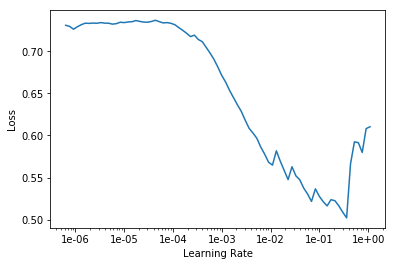

In [37]:
learn.recorder.plot()

In [38]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.215804,0.092350,0.976000,10:55


In [39]:
# learn.save('first')

In [40]:
learn.load('first');

In [41]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.129492,0.076635,0.975500,12:53


In [42]:
# learn.save('second')

In [43]:
learn.load('second');

In [44]:
learn.predict("I really enjoyed our lunch. Went with my wife and kids and had the steak sandwich which was delicious!")

(Category 5, tensor(1), tensor([9.3103e-10, 1.0000e+00]))

In [45]:
learn.predict("These guys were dishonest and service was bad!")

(Category 1, tensor(0), tensor([0.5102, 0.4898]))